# Causal Trees

In this tutorial, we are going to see how to estimate heterogeneous treatment effects using regression trees.

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Decision tree methods
- Propensity score matching

## Setting

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, D_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

Our goal is to estimate the **conditional average treatment effect**

$$
\tau(x) = \mathbb E \Big [ Y^{(1)} - Y^{(0)} \ \Big| \ X = x \Big ]
$$

Crucially, we only get to observe $Y_i = Y_i^{(T_i)}$.

Wihtout further assumptions, we cannot estimate $\tau(x)$.

**Assumption: unconfoundedness** (or ignorability, or selection on observables)

$$
\lbrace Y_i^{(1)} , Y^{(0)} \rbrace \perp W_i \ | \ X_i
$$

i.e. conditional on observable characteristics the treatment assignment is as good as random.

When unconfoundedness holds, matching methods usually provide consistent estimates of the conditional average treatment effect.

## Prediction Problem

How can we make the inference problem a **prediction problem**?

In principle, we would like to divide the population in subgroups in order to minimize the mean squared error (MSE) of treatment effects. 

The objective function is

$$
\sum_i \Big [ ( \tau_i - \hat \tau_i(X))^2 \Big ]
$$

However, this objective function is **unfeasible** since we do not observe $\tau_i$.

The **idea** is to transform our outcome variable as

$$
Y_i^* = \frac{Y_i}{D_i * p(X_i) - (1-D_i) * (1-p(X_i))}
$$

where $p_i$ is the **propensity score** of observation $i$, i.e. its probability of being treated.

It's intuitive to verify that, given this specification, the expected value of $Y_i^*$ is the **conditional average treatment effect**.

Here is a proof:

$$
\begin{aligned}
\mathbb E \left[ Y_i^{*} \mid X_i = x \right] &= \mathbb E \left[ \frac{Y_i}{T_i * p(X_i) - (1-T_i) * (1-p(X_i))} \ \Big | \ X_i = x \right]
\newline
&= \mathbb E \left[ Y_i * \frac{T_i - p(X_i)}{p(X_i) (1-p(X_i))} \ \Big | \ X_i = x \right]
\newline
&= \mathbb E \left[ Y_i T_i * \frac{T_i - p(X_i)}{p(X_i) (1 - p(X_i))} + Y_i (1-T_i) * \frac{T_i - p(X_i)}{p(X_i) (1 - p(X_i))} \ \Big | \ X_i = x \right]
\newline
&= \mathbb E \Big[ Y^{(1)}_i * \frac{D_i (1 - p(X_i))}{p(X_i) (1 - p(X_i))} \ \Big | \ X_i = x \Big] - \mathbb E \left[Y^{(0)}_i * \frac{(1 - T_i) p(X_i)}{p(X_i) (1-p(X_i))} \ \Big | \ X_i = x \right]
\newline
&= \frac{1}{p(X_i)} \mathbb E \Big[ Y^{(1)}_i * T_i \ \Big | \ X_i = x \Big] - \frac{1}{1-p(X_i)} \mathbb E \left[ Y^{(0)}_i * (1 - T_i) \ \Big | \ X_i = x \right]
\newline
&= \frac{1}{p(X_i)} \mathbb E \left[ Y^{(1)}_i \ \Big | \ X_i = x \right] * \mathbb E \Big[ T_i \ \Big | \ X_i = x \Big] - \frac{1}{1 - p(X_i)} \mathbb E \left[ Y^{(0)}_i \ \Big | \ X_i = x \right] * \mathbb E \left[ (1 - T_i) \ \Big | \ X_i = x \right]
\newline
&= \mathbb E \Big[ Y^{(1)}_i \ \Big | \ X_i = x \Big] - \mathbb E \Big[Y^{(0)}_i \ \Big | \ X_i = x \Big]
\newline
&= \tau_i(x)
\end{aligned}
$$

How can **regression trees** help estimate heterogeneous treatment effects? 

If we fit a tree model on the modified outcome $Y^*$, we will get a partition of the data that minimizes the expected mean squared error of the conditional treatment effect. While the individual estimates are going to be inaccurate, within each leaf, we can estimate **heterogeneous treatment effects**.

In order to get an **unbiased estimate** however, we need to use different data to build the tree and to estimate the effect. This procedure comes at the cost of increased variance.

## Example 1: Simulated Data

Let's start with an example on synthetic data. We have the following individual characteristics:

- `male`: gender
- `black`: race
- `age`: age
- `educ`: education, which depends on age and race

Moreover, we maketreatment status `D` depend on both gender and race so that it will be important to condition on observables. 

Our outcome variable `y` depends on the treatment assignment differently according to education and age.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_ad

We generate a dataset out of our DGP.

In [3]:
dgp = dgp_ad()
df = dgp.generate_data()
df.head()

,male,black,age,educ,ad_exposure,revenue
0,0,0,55.0,1,False,-0.327221
1,1,1,47.0,2,False,0.659393
2,0,1,31.0,2,True,2.805178
3,0,1,51.0,2,False,-0.508548
4,0,0,48.0,0,True,0.762280


We can check the distribution of variables across treatment assignment.

In [4]:
df.groupby(dgp.T).agg(['mean', 'std']).T.unstack(1)

ad_exposure     False                  True          
                 mean        std       mean       std
male          0.42000   0.494053   0.592000  0.491955
black         0.58800   0.492688   0.470000  0.499599
age          44.57600  10.350386  44.970000  9.961102
educ          2.19200   1.824773   1.968000  1.724216
revenue      -0.11697   1.057941   1.156387  2.147342

As we can see, `male` and `black` are now balanced across groups.

We can get a first estimate of the **average treatment effect** as a simple comparison of means.

In [5]:
df.loc[df[dgp.T]==1, dgp.Y].mean() - df.loc[df[dgp.T]==0, dgp.Y].mean()

1.2733576182695898

We can visualize the difference with a barplot.

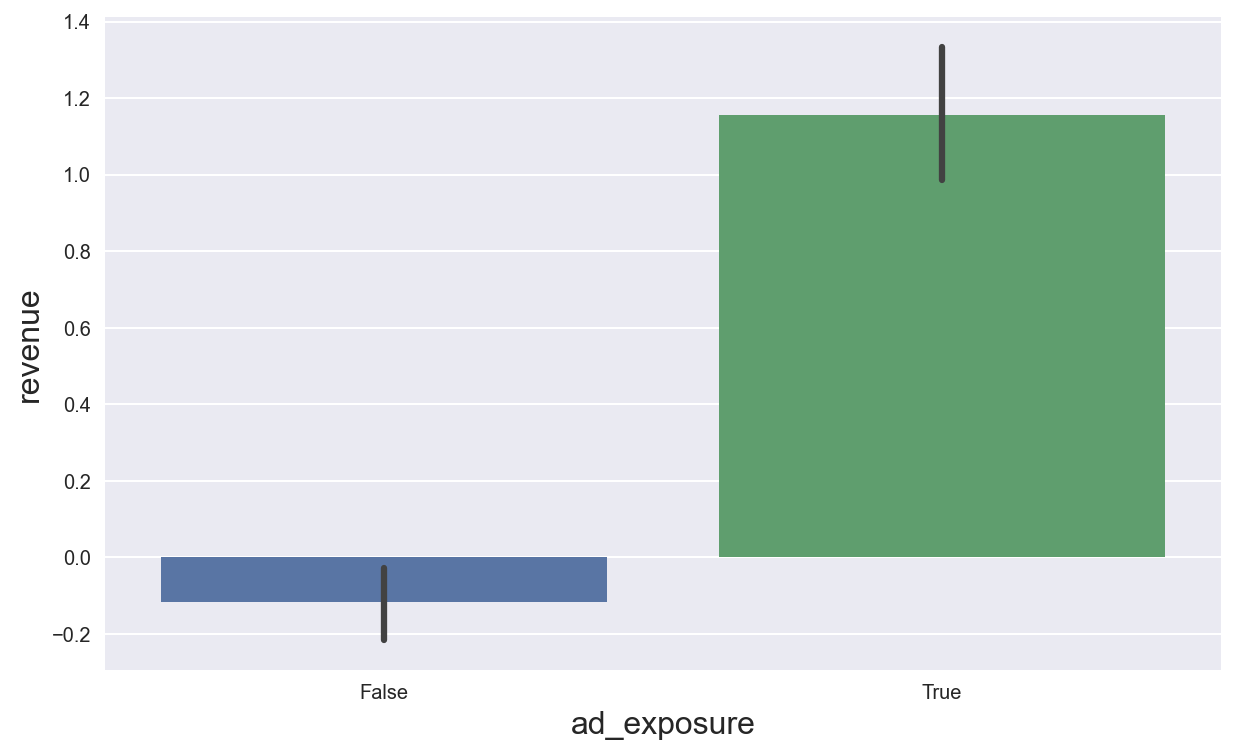

In [6]:
sns.barplot(x=dgp.T, y=dgp.Y, data=df);

It seems there is a significant difference between the two groups. We can get a standard error around the estimate by regressing $Y$ on $D$.

In [8]:
est = smf.ols(f'{dgp.Y} ~ {dgp.T}', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1170,0.076,-1.545,0.123,-0.266,0.032
ad_exposure[T.True],1.2734,0.107,11.894,0.000,1.063,1.483


The coefficient is statistically significant. However, we know that the treatment assignment is not **unconditionally exogenous**. We need to condition on observables $X$. 

In [9]:
est = smf.ols(f'{dgp.Y} ~ {dgp.T} +' + ' + '.join(dgp.X), df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1026,0.247,-0.416,0.678,-0.587,0.382
ad_exposure[T.True],1.0342,0.103,10.044,0.000,0.832,1.236
male,0.9987,0.102,9.765,0.000,0.798,1.199
black,-0.8234,0.126,-6.555,0.000,-1.070,-0.577
age,-0.0050,0.005,-1.001,0.317,-0.015,0.005
educ,0.1240,0.035,3.533,0.000,0.055,0.193


We do not need to actually condition on the full vector of observables $X$. It is sufficient to condition on the **propensity score** $p(X)$, i.e. the conditional probability of treatment.

We can estimate the propensity score with any method we want. The more flexible, the better.

In [10]:
df['pscore'] = RandomForestRegressor().fit(df[dgp.X], df[dgp.T]).predict(df[dgp.X])
df['pscore'].head()

0    0.368726
1    0.036667
2    0.675000
3    0.701702
4    0.307456
Name: pscore, dtype: float64

We now estiamte the conditional average treatment effect regressing $Y$ on $D$ and on the p-score.

In [11]:
est = smf.ols(f'{dgp.Y} ~ {dgp.T} + pscore', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3402,0.103,-3.315,0.001,-0.542,-0.139
ad_exposure[T.True],0.8957,0.159,5.638,0.000,0.584,1.208
pscore,0.8235,0.257,3.204,0.001,0.319,1.328


We are now ready to estimate **heterogeneous treatment effects**. First, we need to compute the transformed outcome

$$
Y_i^* = \frac{Y_i}{T_i * e_i - (1-T_i) * (1-e_i)}
$$

In [12]:
df['y_star'] = df[dgp.Y] /(df[dgp.T] * df['pscore'] - (1-df[dgp.T]) * (1-df['pscore']))

Now we train a small tree on the transformed outcome $Y^*$. 

In [13]:
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=30).fit(df[dgp.X], df['y_star'])
df['y_hat'] = tree.predict(df[dgp.X])

We can plot the tree and visualize the estimated groups and treatment effects.

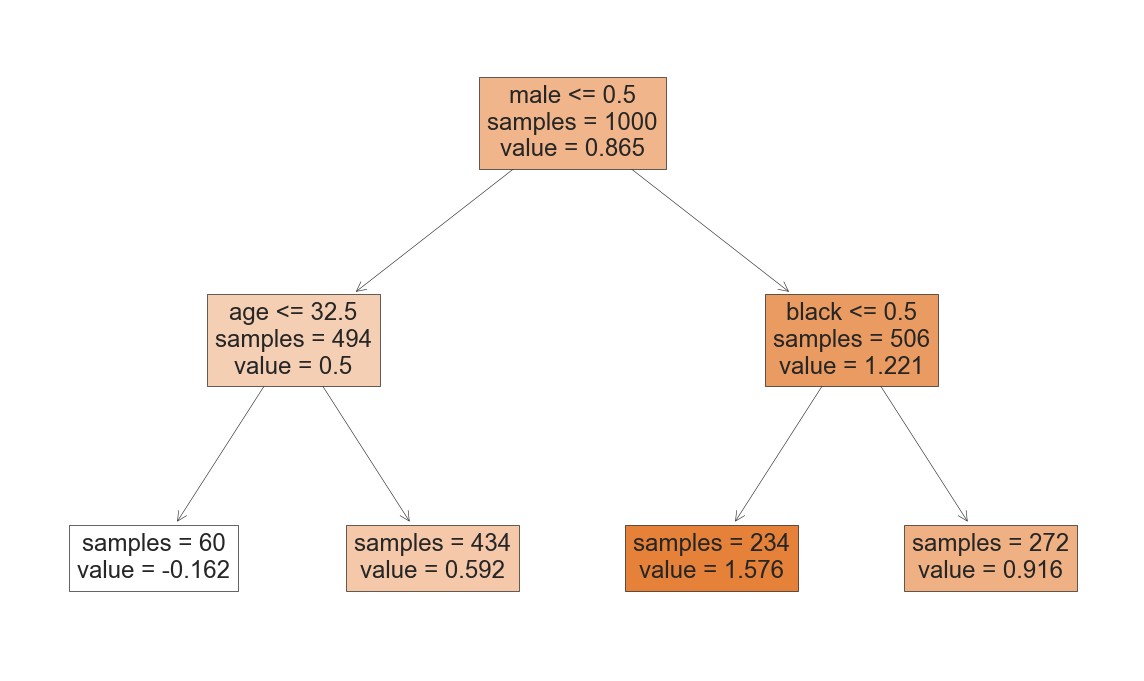

In [14]:
# Plot tree
plot_tree(tree, filled=True, fontsize=12, feature_names=dgp.X, impurity=False);

We still have one issue: we have trained our tree model and estimated the treatment effects using the same data. This introduces bias in the estimates.

In [15]:
from econml.causal_forest import CausalForest

model = CausalForest(max_depth=2).fit(Y=df[dgp.Y], X=df[dgp.X], T=df[dgp.T])

We can plot a tree

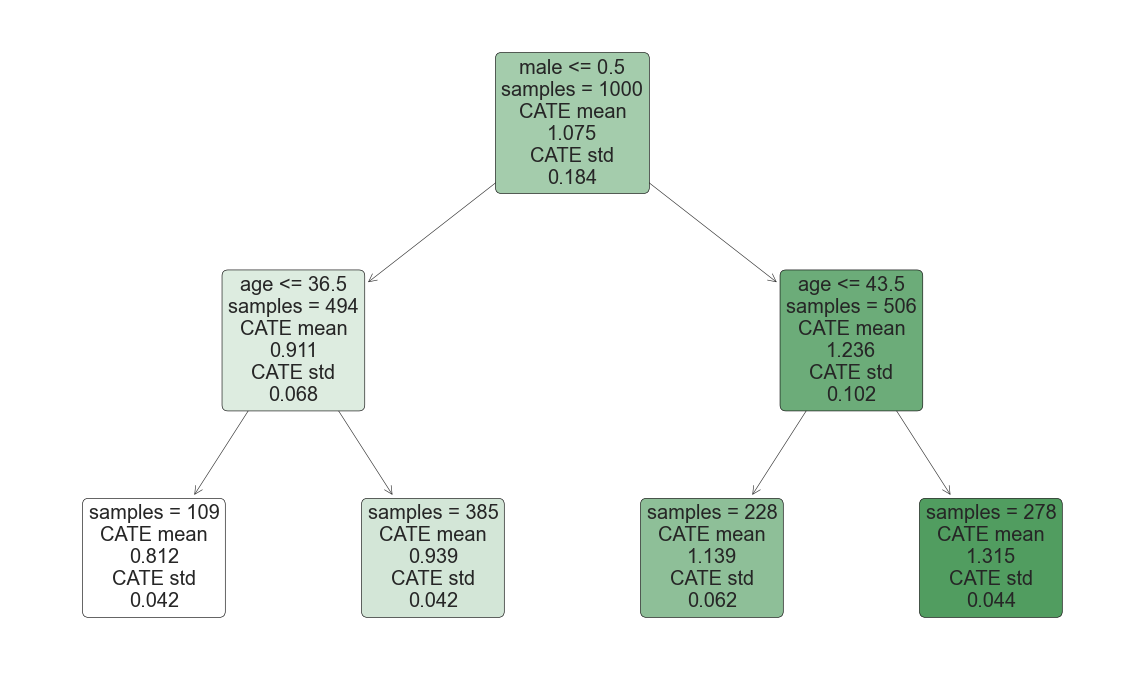

In [16]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(model, df[dgp.X])
intrp.plot(feature_names=dgp.X, fontsize=10)

## Example 2: Lalonde Data

For this tutorial, we are goind to use the data from Lalonde (1981). You can find the data here: https://users.nber.org/~rdehejia/nswdata.html

In [17]:
df = pd.read_csv('data/lalonde86.csv')
df.head()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


We can summarize each variable by its treatment status.

In [18]:
df.groupby('treat').agg(['mean', 'std']).T.unstack(1)

treat              0.0                       1.0             
                  mean          std         mean          std
age          25.053846     7.057745    25.816216     7.155019
education    10.088462     1.614325    10.345946     2.010650
black         0.826923     0.379043     0.843243     0.364558
hispanic      0.107692     0.310589     0.059459     0.237124
married       0.153846     0.361497     0.189189     0.392722
nodegree      0.834615     0.372244     0.708108     0.455867
re74       2107.026658  5687.905694  2095.573689  4886.620353
re75       1266.909002  3102.982044  1532.055314  3219.250870
re78       4554.801126  5483.835991  6349.143530  7867.402218

In [19]:
y = 're78'
D = 'treat'

In [20]:
est = smf.ols('re78 ~ treat', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4554.8011,408.046,11.162,0.000,3752.855,5356.747
treat,1794.3424,632.853,2.835,0.005,550.574,3038.110


In [21]:
X = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree']

In [22]:
est = smf.ols('re78 ~ treat +' + ' + '.join(X), df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1168.0035,3360.588,0.348,0.728,-5436.921,7772.928
treat,1671.1304,637.973,2.619,0.009,417.254,2925.007
age,52.8219,45.255,1.167,0.244,-36.123,141.767
education,393.8213,227.114,1.734,0.084,-52.549,840.192
black,-2220.2622,1168.317,-1.900,0.058,-4516.480,75.956
hispanic,83.7193,1550.348,0.054,0.957,-2963.346,3130.785
married,158.2084,850.326,0.186,0.852,-1513.029,1829.446
nodegree,-128.2203,995.416,-0.129,0.898,-2084.617,1828.177


In [23]:
df['pscore'] = RandomForestRegressor().fit(df[X], df[D]).predict(df[X])
df['pscore'].head()

0    0.810000
1    0.752000
2    0.485786
3    0.670023
4    0.731667
Name: pscore, dtype: float64

In [24]:
est = smf.ols('re78 ~ treat + pscore', df).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4313.9001,591.433,7.294,0.000,3151.530,5476.270
treat,1461.6324,866.171,1.687,0.092,-240.692,3163.957
pscore,894.6072,1588.766,0.563,0.574,-2227.867,4017.082


Estimate CATE

In [25]:
from econml.causal_forest import CausalForest

model = CausalForest(max_depth=2).fit(Y=df[y], X=df[X], T=df[D])

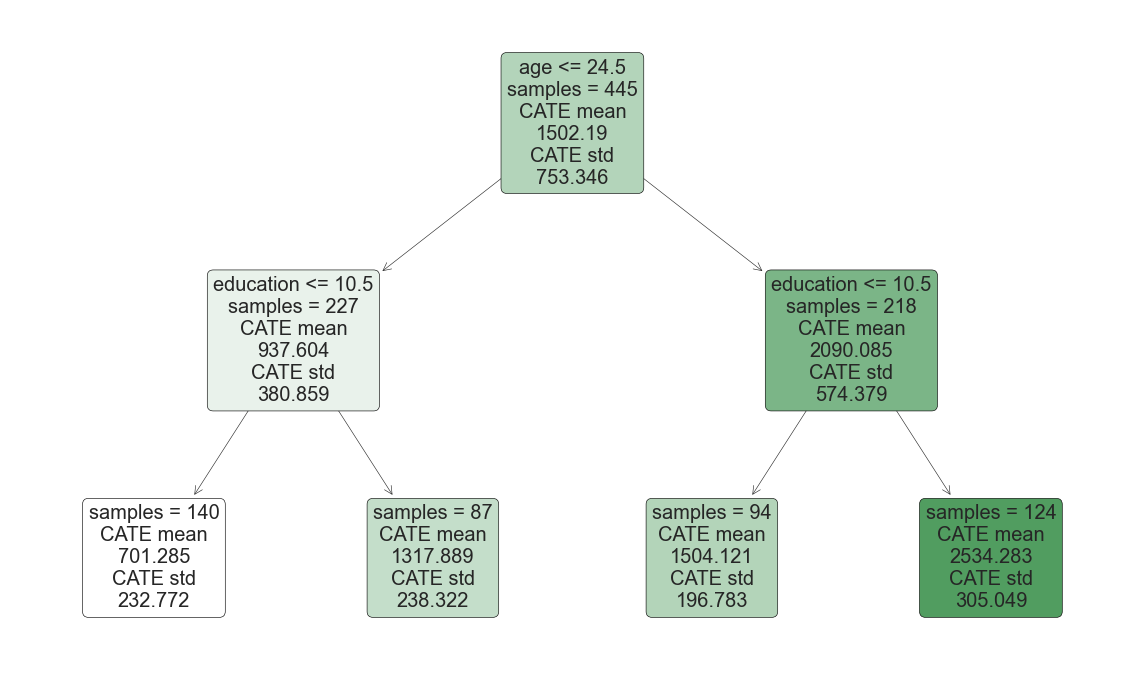

In [26]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(model, df[X])
intrp.plot(feature_names=X, fontsize=10)

## References

- Original paper: [Recursive partitioning for heterogeneous causal effects](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) (2016) by Athey and Imbens
- [Video lecture](https://www.youtube.com/watch?v=JtDRpM6Mnnw) by Prof. Susan Athey (Stanford)